In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
# from statsmodels.tsa.arima_model import ARMA
register_matplotlib_converters()
from time import time

# Catfish Sales Data

In [2]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [ ]:
#read data, Pandas 2.0+
catfish_sales = pd.read_csv('catfish.csv', parse_dates=[0], index_col=0)
catfish_sales = catfish_sales.squeeze()

In [5]:
#read data
# catfish_sales = pd.read_csv('catfish.csv', parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

In [6]:
#infer the frequency of the data
catfish_sales = catfish_sales.asfreq(pd.infer_freq(catfish_sales.index))

In [7]:
start_date = datetime(2000,1,1)
end_date = datetime(2004,1,1)
lim_catfish_sales = catfish_sales[start_date:end_date]

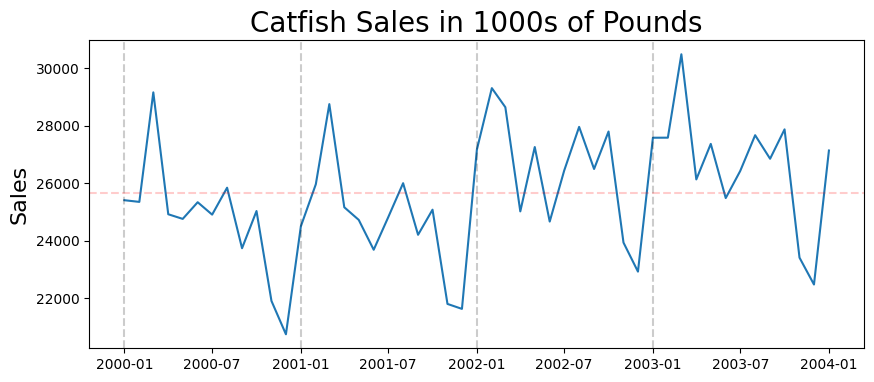

In [11]:
plt.figure(figsize=(10,4))
plt.plot(lim_catfish_sales)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(lim_catfish_sales.mean(), color='r', alpha=0.2, linestyle='--')

In [10]:
# Make it stationary
# Take the first difference
# This is the difference between the current value and the previous value
first_diff = lim_catfish_sales.diff()[1:]

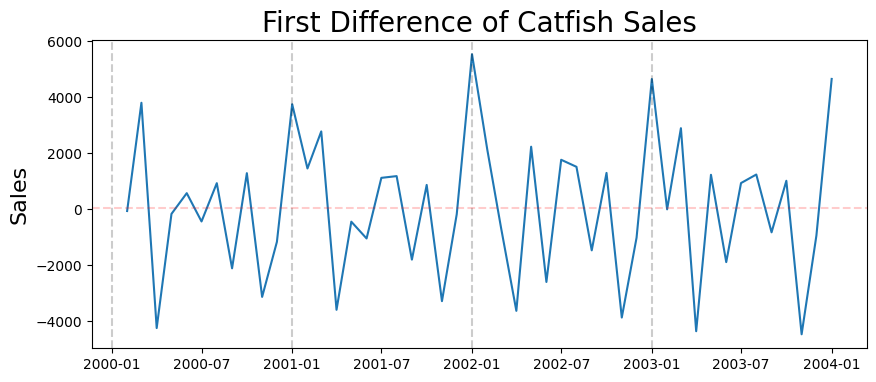

In [12]:
plt.figure(figsize=(10,4))
plt.plot(first_diff)
plt.title('First Difference of Catfish Sales', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(first_diff.mean(), color='r', alpha=0.2, linestyle='--')

# ACF

<BarContainer object of 17 artists>

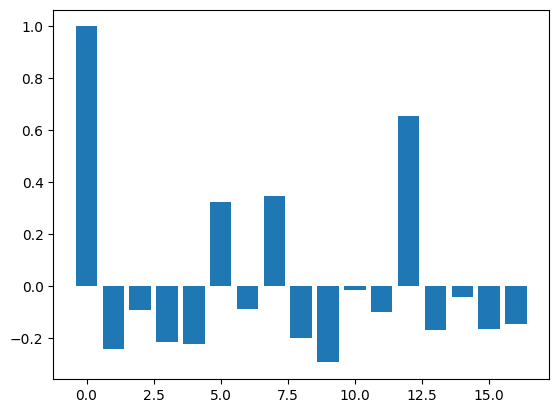

In [14]:
acf_vals = acf(first_diff)
num_lags = min(20, len(acf_vals))
plt.bar(range(num_lags), acf_vals[:num_lags])

#num_lags = min(20, len(acf_vals))
#acf_vals = acf(first_diff)
#plt.bar(range(num_lags), acf_vals[:num_lags])

## Based on ACF, we should start with a MA(1) process

This recommendation comes from how the **Autocorrelation Function (ACF)** behaves for different time series models:

- For a **Moving Average (MA) process of order q**, the ACF will show significant spikes at lag 1 up to lag q, and then drop to (or near) zero for higher lags.
- For an **MA(1)** process, only the lag 1 autocorrelation is significant; all higher lags are close to zero.

**So, if your ACF plot shows:**
- A large spike at lag 1,
- All other lags (2, 3, ...) are near zero,

…it suggests the data can be modeled well by an MA(1) process.

**In summary:**  
The ACF pattern matches the theoretical behavior of an MA(1) model, so it’s a good starting point for modeling.

# PACF

<BarContainer object of 17 artists>

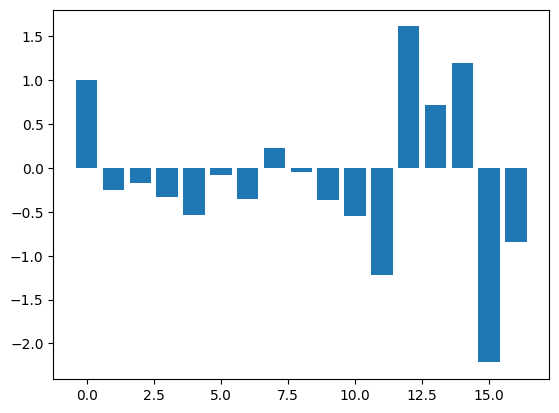

In [16]:
pacf_vals = pacf(first_diff)
plt.bar(range(num_lags), pacf_vals[:num_lags])

## Based on PACF, we should start with a AR(4) process

# Get training and testing sets

In [17]:
train_end = datetime(2003,7,1)
test_end = datetime(2004,1,1)

train_data = first_diff[:train_end]
test_data = first_diff[train_end + timedelta(days=1):test_end]

# Fit the ARMA Model

**ARMA** and **ARIMA** are both time series models, but they differ in how they handle non-stationary data:

---

### ARMA (AutoRegressive Moving Average)
- **Model:** ARMA(p, q)
- **Components:**  
  - **AR (p):** Autoregressive part (uses past values)
  - **MA (q):** Moving average part (uses past errors)
- **Requirement:** The time series must be **stationary** (constant mean and variance over time).
- **No differencing** is included in the model.

---

### ARIMA (AutoRegressive Integrated Moving Average)
- **Model:** ARIMA(p, d, q)
- **Components:**  
  - **AR (p):** Autoregressive part  
  - **I (d):** **Integrated** part (**differencing** to make the series stationary)  
  - **MA (q):** Moving average part
- **Requirement:** Can handle **non-stationary** data by differencing it `d` times.
- **Differencing** is included as part of the model.

---

**Summary:**  
- Use **ARMA** for stationary data.
- Use **ARIMA** for non-stationary data (with differencing).

**In modern `statsmodels`, use `statsmodels.tsa.arima.model.ARIMA` for both ARMA and ARIMA models by setting `d=0` for ARMA.**

In [40]:
# define model
model = ARIMA(train_data, order=(4,0, 0))

In [41]:
#fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

Model Fitting Time: 0.05060243606567383


In [42]:
#summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Total   No. Observations:                   42
Model:                 ARIMA(4, 0, 0)   Log Likelihood                -376.999
Date:                Tue, 20 May 2025   AIC                            765.998
Time:                        15:05:43   BIC                            776.424
Sample:                    02-01-2000   HQIC                           769.819
                         - 07-01-2003                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         24.1669    124.171      0.195      0.846    -219.203     267.537
ar.L1         -0.5024      0.127     -3.956      0.000      -0.751      -0.254
ar.L2         -0.3082      0.160     -1.928      0.0

## So the ARMA(4,1) model is:

## $\hat{y_t} = -0.87y_{t-1} - 0.42y_{t-2} - 0.56y_{t-3} - 0.61y_{t-4} + 0.52\varepsilon_{t-1}$

In [43]:
#get prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

In [44]:
#get the predictions and residuals
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data - predictions

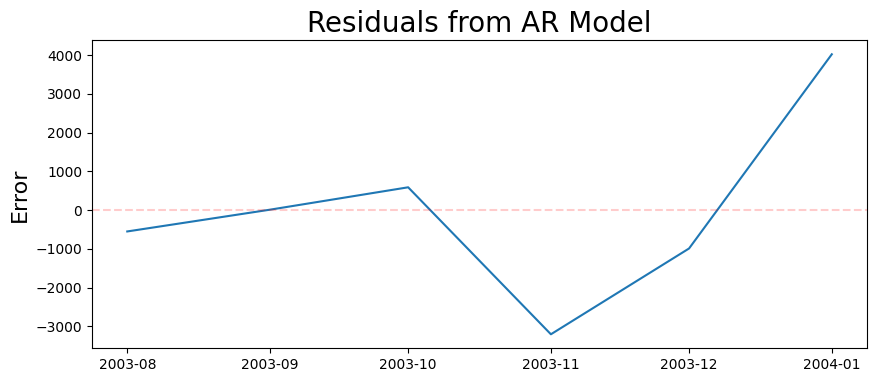

In [45]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)

Text(0, 0.5, 'Sales')

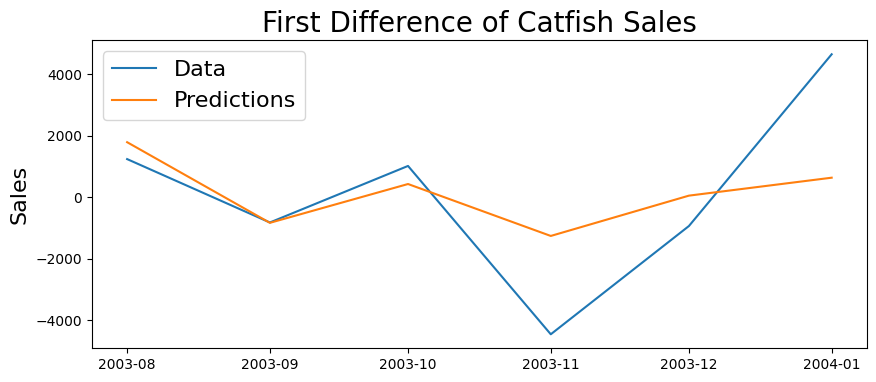

In [46]:
plt.figure(figsize=(10,4))

plt.plot(test_data)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('First Difference of Catfish Sales', fontsize=20)
plt.ylabel('Sales', fontsize=16)

In [47]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 2161.29531764114


**ARMA** and **ARIMA** are both time series models, but they differ in how they handle non-stationary data:

---

### ARMA (AutoRegressive Moving Average)
- **Model:** ARMA(p, q)
- **Components:**  
  - **AR (p):** Autoregressive part (uses past values)
  - **MA (q):** Moving average part (uses past errors)
- **Requirement:** The time series must be **stationary** (constant mean and variance over time).
- **No differencing** is included in the model.

---

### ARIMA (AutoRegressive Integrated Moving Average)
- **Model:** ARIMA(p, d, q)
- **Components:**  
  - **AR (p):** Autoregressive part  
  - **I (d):** **Integrated** part (**differencing** to make the series stationary)  
  - **MA (q):** Moving average part
- **Requirement:** Can handle **non-stationary** data by differencing it `d` times.
- **Differencing** is included as part of the model.

---

**Summary:**  
- Use **ARMA** for stationary data.
- Use **ARIMA** for non-stationary data (with differencing).

**In modern `statsmodels`, use `statsmodels.tsa.arima.model.ARIMA` for both ARMA and ARIMA models by setting `d=0` for ARMA.**